## CS310 Natural Language Processing
## Lab 4 (part 2): Data preparation for implementing word2vec

skipgram architecture and negative sampling method

In [15]:
from typing import List
from pprint import pprint
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [16]:
# We set min_count=1 to include all words in the corpus
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)

Total vocabulary: 1352


In [17]:
print(corpus.word2id["子"])
print(corpus.id2word[1])
print(len(corpus.id2word))

1
子
1352


## Efficient way for negative sampling

In `utils.CorpusReader` class, we have implemented a method `initTableNegatives`. It creates a list of words (`self.negatives`) with a size of 1e8. This size is set a large value so that it scales up to very large corpus. 

The list contains the index of each word in the vocabulary, whose probability is proportional to the power of 0.75 of the word's original frequency count. 



In [18]:
# This is a simulation of how initTableNegatives works
# The impl. in utils.py is a bit different, but the idea is the same
word_frequency = {"a": 1, "b": 2, "c": 3, "d": 4}

# the scaled sum of frequencies Z = 1**0.75 + 2**0.75 + 3**0.75 + 4**0.75 = 7.7897270
# then the scaled probability of a = 1**0.75 / Z = 0.12837420128374202
# the scaled probability of b = 2**0.75 / Z = 0.21589881215898812
# the scaled probability of c = 3**0.75 / Z = 0.29262990292629903
# the scaled probability of d = 4**0.75 / Z = 0.3630970836309708

def initTableNegatives():
    pow_frequency = np.array(list(word_frequency.values())) ** 0.75
    words_pow = sum(pow_frequency)
    ratio = pow_frequency / words_pow
    count = np.round(ratio * CorpusReader.NEGATIVE_TABLE_SIZE)
    negatives = []
    for wid, c in enumerate(count):
        negatives += [wid] * int(c)
    negatives = np.array(negatives)
    np.random.shuffle(negatives)
    return negatives

negatives = initTableNegatives()

In [19]:
print(len(negatives))
print(set(negatives)) # the word indices: a -> 0, b -> 1, c -> 2, d -> 3
print(np.sum(negatives == 0) / len(negatives)) # should be the scaled probability of a
print(np.sum(negatives == 1) / len(negatives)) # should be the scaled probability of b
print(np.sum(negatives == 2) / len(negatives)) # should be the scaled probability of c
print(np.sum(negatives == 3) / len(negatives)) # should be the scaled probability of d

99999999
{0, 1, 2, 3}
0.12837420128374202
0.21589881215898812
0.29262990292629903
0.3630970836309708


Next, the `getNegatives` method returns the negative samples for a target word. The idea is to chop off a segment of given `size` from the `negatives` list. 

If the segment contains the target word, it is discarded and a new segment is taken. This is done to avoid the target word itself to be sampled as a negative.

In [20]:
# Test some examples
corpus.getNegatives(target=1, size=5)

array([ 87,  40, 528, 243, 275])

## T1. Generate data for training

Now we are going to implement the sliding window to generate center, outside, and negative words for each position in a sentence.

- It takes a list of words as input and go through each word as a center word.
- For each center word, both the left and right `window_size` words are considered as outside words. This number is smaller near the two ends of the sentence.
- Call `corpus.getNegatives` to get negative samples for each center word.

In [21]:
def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### START YOUR CODE ###
    word_ids = [corpus.word2id[word] for word in words]
    
    for i, center in enumerate(word_ids):
        # 对每个中心词获取上下文窗口内的词
        start = max(0, i - window_size)
        end = min(len(word_ids), i + window_size + 1)
        
        outside_words = word_ids[start:i] + word_ids[i+1:end]
        neg_samples = corpus.getNegatives(center, k)
        
        for outside in outside_words:
            yield center, outside, neg_samples
    ### END YOUR CODE ###

In [22]:
# Test generate_data
text = "学而时习之"
words = list(text)
print('words:', words)
print('word ids:', [corpus.word2id[word] for word in words])

# first center word is 学
print()
print(f'When window size is 3, for center word 学 -> {corpus.word2id["学"]}')
print(f'the outside words are: ')
print(f'而 -> {corpus.word2id["而"]}')
print(f'时 -> {corpus.word2id["时"]}')
print(f'习 -> {corpus.word2id["习"]}')

print()
print('output from generate_data:')
data = list(generate_data(list(text), window_size=3, k=5, corpus=corpus))
pprint(data[:3])


### You are expected to see the following output:
### Note that the negative samples are random, so you may see different numbers
# words: ['学', '而', '时', '习', '之']
# word ids: [46, 8, 224, 544, 5]

# When window size is 3, for center word 学 -> 46
# the outside words are: 
# 而 -> 8
# 时 -> 224
# 习 -> 544

# output from generate_data:
# [(46, 8, array([354,   3, 831, 570,  27])),
#  (46, 224, array([1077, 1095,   89,  340,   92])),
#  (46, 544, array([ 49, 488,   4, 269,  30]))]

words: ['学', '而', '时', '习', '之']
word ids: [46, 8, 224, 544, 5]

When window size is 3, for center word 学 -> 46
the outside words are: 
而 -> 8
时 -> 224
习 -> 544

output from generate_data:
[(46, 8, array([ 29,  63, 210, 256,   4])),
 (46, 224, array([ 29,  63, 210, 256,   4])),
 (46, 544, array([ 29,  63, 210, 256,   4]))]


However, the above data are not in batch. We want all center words are batched into a tensor of dimension `batch_size`; same for the outside words and negative samples.

For example, in "学而时习之", if `batch_size` is 4, then the returned batch[0] will contain three tensors. 
- The first tensor contains center words, i.e., 3 "学" plus 1 "而" => [46, 46, 46, 8]
- The second tensor contains the correponding outside words, i.e., "而", "时", and "习" for "学"; "学" for "而" => [8, 224, 544,  46]
- The third tensor contains the negative samples, whose dimension is `batch_size` $\times$ `k`
  
The data type of the tensors is `torch.long`.

In [23]:
def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        centers = []
        outsides = []
        negatives = []
        
        for center, outside, negative in batch:
            centers.append(center)
            outsides.append(outside)
            negatives.append(negative)
        
        # 使用yield而不是return
        yield (torch.tensor(centers, dtype=torch.long),
               torch.tensor(outsides, dtype=torch.long),
               torch.tensor(negatives, dtype=torch.long))

In [24]:
# Test batchify

text = "学而时习之"
words = list(text)
data = list(generate_data(words, window_size=3, k=5, corpus=corpus))

batches = list(batchify(data, batch_size=4))
print(batches[0])

print(batches)
### You are expected to see the following output:
### Note that the negative samples are random, so you may see different numbers
# (tensor([46, 46, 46,  8]), tensor([  8, 224, 544,  46]), tensor([[  85,    3,   72,   26,   35],
#         [   7,    1,  487,   20,    4],
#         [  12,  227,    2,   25,  639],
#         [ 582,  148,   15, 1203,   85]]))

(tensor([46, 46, 46,  8]), tensor([  8, 224, 544,  46]), tensor([[ 776,    0,  101,  237,   47],
        [ 776,    0,  101,  237,   47],
        [ 776,    0,  101,  237,   47],
        [  59, 1282,  969,  870,   28]]))
[(tensor([46, 46, 46,  8]), tensor([  8, 224, 544,  46]), tensor([[ 776,    0,  101,  237,   47],
        [ 776,    0,  101,  237,   47],
        [ 776,    0,  101,  237,   47],
        [  59, 1282,  969,  870,   28]])), (tensor([  8,   8,   8, 224]), tensor([224, 544,   5,  46]), tensor([[  59, 1282,  969,  870,   28],
        [  59, 1282,  969,  870,   28],
        [  59, 1282,  969,  870,   28],
        [   1,    7, 1051,  293,    1]])), (tensor([224, 224, 224, 544]), tensor([  8, 544,   5,  46]), tensor([[   1,    7, 1051,  293,    1],
        [   1,    7, 1051,  293,    1],
        [   1,    7, 1051,  293,    1],
        [   2,  169,   14,    1,  137]])), (tensor([544, 544, 544,   5]), tensor([  8, 224,   5,   8]), tensor([[  2, 169,  14,   1, 137],
        [  2, 16

## T2. Implement the SkipGram class

`SkipGram` is a subclass of `nn.Module`. The two key components are:
- `__init__`: initialize the embeddings
  - Two `nn.Embedding` objects are created: `self.emb_v` for center words; `self.emb_u` for outside words and negative samples.
  - Each `nn.Embedding` is created with `vocab_size` and `emb_dim` as input arguments. 
  - `self.emb_v` is initialized with uniform distribution; `self.emb_u` is initialized with zeros.
- `forward`: given input tensors, return the loss of the model
  - Takes three tensors as input: center words, outside words, and negative samples. They are the output from the previously defined `batchify` function.
  - Compute the loss using the formula: $-\log\sigma(v_c \cdot u_o) - \sum_{k=1}^K \log\sigma(-v_c \cdot u_k)$

*Hint*:
- For the $\log\sigma$ function, you can use `F.logsigmoid` in PyTorch. See the imported module: `import torch.nn.functional as F`
- If the input to `F.logsigmoid` is too large, it will return 0, which is not good for training. You can use `torch.clamp` to limit the input to a certain range. For example, `torch.clamp(x, min=-10, max=10)` will limit the input to be in the range of $[-10, 10]$.

In [25]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### START YOUR CODE ###
        # 计算正样本的得分
        pos_score = torch.sum(v_c * u_o, dim=1)  # (B,)
        pos_score = torch.clamp(pos_score, min=-10, max=10)
        pos_loss = F.logsigmoid(pos_score)
        
        # 计算负样本的得分
        neg_score = torch.bmm(u_n, v_c.unsqueeze(2)).squeeze()  # (B, k)
        neg_score = torch.clamp(neg_score, min=-10, max=10)
        neg_loss = F.logsigmoid(-neg_score).sum(1)  # 对k个负样本求和
        
        # 总损失
        loss = -(pos_loss + neg_loss)
        
        return loss     
        ### END YOUR CODE ###

    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [26]:
# Test the model
vacob_size =len(corpus.id2word)
emb_size = 32
model = SkipGram(vacob_size, emb_size)

weight = torch.empty(vacob_size, emb_size)
start_value = 0.01
for i in range(vacob_size):
    weight[i] = start_value + i * 0.01

model.emb_v.weight.data.copy_(weight)
model.emb_u.weight.data.copy_(weight)

# Test the model
center = torch.tensor([0, 1, 2, 3, 4])
outside = torch.tensor([0, 1, 2, 3, 4])
negative = torch.tensor([[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]])
with torch.no_grad():
    loss = model(center, outside, negative)
print(loss)


### You are expected to see the following output:
# tensor([4.1814, 4.2008, 4.2172, 4.2307, 4.2414])


tensor([4.1814, 4.2008, 4.2172, 4.2307, 4.2414])


开始训练...
Epoch 1, Average Loss: 3.0877
Epoch 2, Average Loss: 2.6403
Epoch 3, Average Loss: 2.4554
Epoch 4, Average Loss: 2.2916
Epoch 5, Average Loss: 2.1518
Epoch 6, Average Loss: 2.0441
Epoch 7, Average Loss: 1.9662
Epoch 8, Average Loss: 1.9093
Epoch 9, Average Loss: 1.8679
Epoch 10, Average Loss: 1.8379

训练完成！


/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_88684/602961008.py:28: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  plt.savefig('lab4_embeddings.png', dpi=300, bbox_inches='tight')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_88684/602961008.py:28: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  plt.savefig('lab4_embeddings.png', dpi=300, bbox_inches='tight')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_88684/602961008.py:28: UserWarning: Glyph 26352 (\N{CJK UNIFIED IDEOGRAPH-66F0}) missing from current font.
  plt.savefig('lab4_embeddings.png', dpi=300, bbox_inches='tight')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_88684/602961008.py:28: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  plt.savefig('lab4_embeddings.png', dpi=300, bbox_inches='tight')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_88684

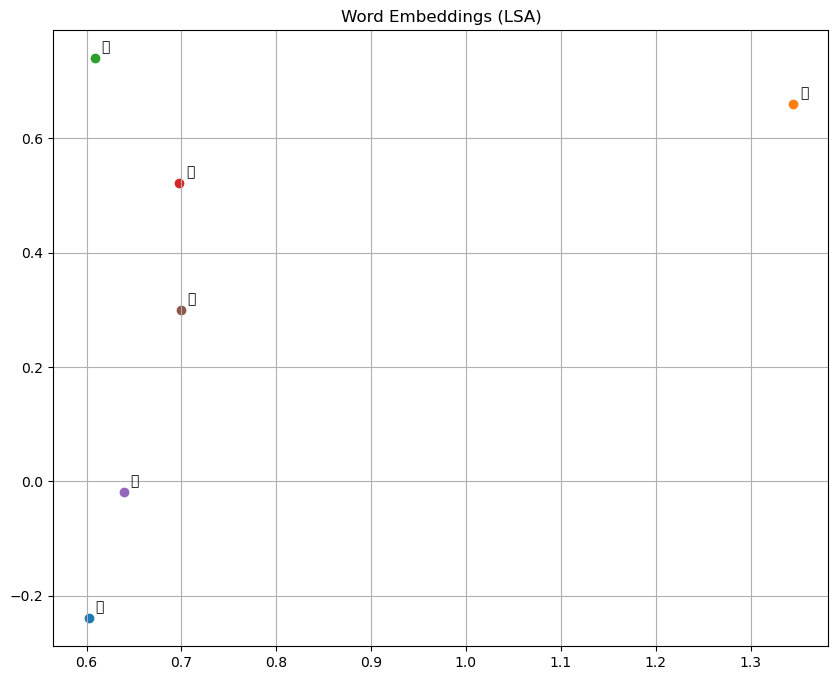


解释方差比: 0.0895
词对相似度分析：
学-习: 0.2292
子-曰: 0.4987
人-仁: 0.1127


In [27]:
# 在notebook最后添加以下代码

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

def visualize_embeddings(model, corpus, target_words=['学', '习', '曰', '子', '人', '仁']):
    """可视化词嵌入"""
    # 获取词嵌入
    embeddings = model.emb_v.weight.detach().cpu().numpy()
    
    # 使用TruncatedSVD降维到2维
    svd = TruncatedSVD(n_components=2)
    embeddings_2d = svd.fit_transform(embeddings)
    
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 绘制目标词
    for word in target_words:
        if word in corpus.word2id:
            idx = corpus.word2id[word]
            x, y = embeddings_2d[idx]
            plt.scatter(x, y, marker='o')
            plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points')
    
    plt.title('Word Embeddings (LSA)')
    plt.grid(True)
    plt.savefig('lab4_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 返回解释方差比
    return svd.explained_variance_ratio_.sum()

def analyze_word_pairs(model, corpus, word_pairs=[('学', '习'), ('子', '曰'), ('人', '仁')]):
    """分析词对之间的关系"""
    embeddings = model.emb_v.weight.detach().cpu().numpy()
    
    print("词对相似度分析：")
    for word1, word2 in word_pairs:
        if word1 in corpus.word2id and word2 in corpus.word2id:
            idx1 = corpus.word2id[word1]
            idx2 = corpus.word2id[word2]
            vec1 = embeddings[idx1]
            vec2 = embeddings[idx2]
            
            # 计算余弦相似度
            similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            print(f"{word1}-{word2}: {similarity:.4f}")

# 训练模型并分析结果
vocab_size = len(corpus.id2word)
emb_size = 100  # 使用与新实验相同的维度
model = SkipGram(vocab_size, emb_size)

# 读取文本
with open("lunyu_20chapters.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    words = list(text.replace('\n', '').replace(' ', ''))

# 生成训练数据
data = list(generate_data(words, window_size=3, k=5, corpus=corpus))

# 训练模型
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)
batch_size = 128
num_epochs = 10

print("开始训练...")
for epoch in range(num_epochs):
    total_loss = 0
    batch_count = 0
    
    for batch in batchify(data, batch_size):
        center, outside, negative = batch
        optimizer.zero_grad()
        loss = model(center, outside, negative)
        loss.mean().backward()
        optimizer.step()
        
        total_loss += loss.mean().item()
        batch_count += 1
        
    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

print("\n训练完成！")

# 可视化结果
explained_variance = visualize_embeddings(model, corpus)
print(f"\n解释方差比: {explained_variance:.4f}")

# 分析词对关系
analyze_word_pairs(model, corpus)

# 保存词向量
model.save_embedding(corpus.id2word, "lab4_embeddings.txt")